### Import packages for the simulation

In [2]:
# Normal staple packages
import sys 
import numpy as np
from numpy import pi as pi, sin as sin, cos as cos, tan as tan, arctan as arctan, arccos as arccos, arcsin as arcsin, exp as exp, log as log, sqrt as sqrt
%matplotlib inline 
# notebook
import matplotlib.pyplot as plt
import scipy.io as sio

# Bloch simulator 
from bloch.bloch import bloch
from bloch.min_time_gradient import minimum_time_gradient

# Biot Savart
sys.path.append('biot-savart-master')
import biot_savart_v4_3 as bs



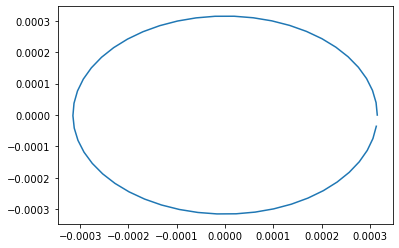

In [6]:
# create the indeces in radians for which to generate the coil. 10 loops so the range is 0 to 10*2*pi. 50*10 = 500 points total.
pis = np.linspace(0,10*2*pi,500)

# create a numpy list of x,y,z points of the coil based of the pis indeces. Make the coil 630um in diameter
coil = np.array([315e-6*cos(pis), 315e-6*sin(pis), np.zeros(500)]).T

# to each point in the coil, append a value of 1s that will represent current through the segment in amps
coil = np.append(coil, np.ones((500,1)), axis=1)

# create a range of 10 current values from 50uA-700uA
currents = np.linspace(50e-6,700e-6,10)

# duplicate the coil list 10 times, and multiply the right value of 1 by the respective current value generated above
coils = [] 
for current in currents:
    coiltoappend = coil.copy()
    coiltoappend[:,3] *= current
    coils.append(coiltoappend)

# save the 10 coils in files in a folder called 'coils'. save them as comma separated text files with the current value in the name
for i, coil in enumerate(coils):
    np.savetxt('coils/coil_'+str(currents[i])+'A.txt', coil, delimiter=', ')

# sanity plot a coil
plt.plot(coil[:50,0], coil[:50,1])

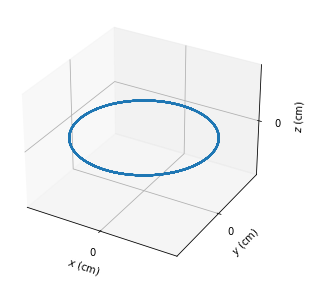

In [5]:
# generate a target volume from the coil stored at coils/coil_0.0007A.txt
#bs.write_target_volume("coils/coil_0.0007A.txt", "coil", (30, 15, 15), (-5, -0.5, -2.5), 1, 1)


# show one of the coils generated
bs.plot_coil("coils/coil_0.0007A.txt")


### Define the grid of spins for our simulation. 

In [2]:
class SpinGrid:
    height = 10 # height of the grid in cm 
    width = 10 # width of the grid in cm
    flow_rate = 5 # flow rate in cm/s. assume vertical flow, with positive corresponding to going up. 
    # area of the grid where the flow is present given by a min and max x coordinate.
    # assume that all flowing material is blood, the rest is muscle. 
    flow_region = [-2, 2] 
    delta_x = 0.1 # grid spacing in cm
    delta_y = 0.1 # grid spacing in cm
    coil_file= None # file containing the shape of the coil, will be used to generate the coil field. 
    
    # TODO: fill in appropraite T1s, and name of other material. 
    T1_moving = -1 
    T2_moving = -1
    T1_static = -1
    T2_static = -1
    M_0 = 1 # initial magnetization of fresh spins 


    def __init__(self, height, width, flow_rate, flow_region):
        self.height = height
        self.width = width
        self.flow_rate = flow_rate
        self.flow_region = flow_region

        # TODO: create a grid of positions, magnetizations, T1s, and T2s. Additionally, calculate 
        # a list of indices for the flowing vs. static columns. 
        
        # Init basic, stationary 
        # ====================================== wall this but make it vertical
        # ====================================== wall
        # ====================================== wall
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ blood
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ blood
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ blood
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ blood


    def simulate_flow(self, delta_t):
        """ 
            Simulate the flow of blood through the grid
            delta_t: time to simulate in seconds
            
            Updates the grid by shifting the flowing columns appropriately. 
            Additionaly fills in fresh material in the space the flow has moved out of. 
        """
        # TODO: fill this in 
        pass

    
    def get_all_positions(self):
        """
            Return a 2 x num_spins array of all of the positions in the grid    
        """
        # TODO: fill this in 
        pass

    def get_static_positions(self):
        """
            Return a 2 x num_static array of all of the positions of the static material   
        """
        # TODO: fill this in
        pass
    
    def get_moving_positions(self):
        """
            Return a 2 x num_moving array of all of the positions of the moving material    
        """
        # TODO: fill this in 
        pass 

    def get_static_magnetizations(self):
        """
            Return a 2 x num_static array of the static magnetizations, indexed the same as the positions.    
        """
        # TODO: fill this in 
        pass

    def get_moving_magnetizations(self):
        """
            Return a 2 x num_moving array of the moving magnetizations, indexed the same as the positions.
        """
        # TODO: fill this in 
        pass

    def visualize_grid(self):
        """
            Visualize the grid, and the flow region.
        """
        # TODO: fill this in
        pass 

    def gen_save_coils(self, x, y):
        # create the indeces in radians for which to generate the coil. 10 loops so the range is 0 to 10*2*pi. 50*10 = 500 points total.
        pis = np.linspace(0,10*2*pi,500)

        # create a numpy list of x,y,z points of the coil based of the pis indeces. 
        # Make the coil 630um in diameter
        # center the coil around x, y
        # Add 4th dimension to represent current through the segment, set to 1 for now
        coil = np.array([315e-6*cos(pis)+x, 315e-6*sin(pis)+y, np.zeros(500), np.ones(500)]).T

        # create a  of 10 currerangent values from 50uA-700uA
        currents = np.linspace(50e-6,700e-6,10)

        # duplicate the coil 10 times, and multiply the right value of 1 by the respective current value generated above
        coils = [] 
        for current in currents:
            coiltoappend = coil.copy()
            coiltoappend[:,3] *= current
            coils.append(coiltoappend)

        # save the 10 coils in files in a folder called 'coils'. save them as text files with the current value in the name
        for i, coil in enumerate(coils):
            np.savetxt('coils/coil_'+str(currents[i])+'A.txt', coil)

    def off_resonance_from_coil(self):
        """
            Return a [2 x num_spins] array of the off resonance frequency of each spin, in Hz.
        """
        pass
        
    def off_resonance_from_coil_static(self):
        """
            Return a [2 x num_static] array of the off resonance frequency of each static spin, in Hz.
        """
        pass

    def off_resonance_from_coil_moving(self):
        """
            Return a [2 x num_moving] array of the off resonance frequency of each moving spin, in Hz.
        """
        pass 

    def plot_coil_field(self):
        """
            Plot the field of the coil. 
        """
        pass



### Simulate and visualize flow on its own without imaging to make sure we can make things flow 


In [3]:
# TODO: set the magnetizations different, then go through several steps of flow and plot at each moment 
# to show the movement of the material and the replenishing of fresh material 

### Create a sequence. 
This will correspond to: b1 (rf) [1 x M], gr (2xM), and readout_indices

In [4]:
def create_ssfp_sequence(TR, echo_time, dt, total_time):
    """
        Creates an SSFP sequence with the given parameters. 
    """
    # TODO: fill in this 
    pass 


### Simulate the sequence 

In [5]:
?bloch

Signature: bloch(b1, gr, tp, t1, t2, df, dp, mode, mx=None, my=None, mz=None)
Docstring:
Bloch simulation of rotations due to B1, gradient and
off-resonance, including relaxation effects.  At each time
point, the rotation matrix and decay matrix are calculated.
Simulation can simulate the steady-state if the sequence
is applied repeatedly, or the magnetization starting at m0.

INPUT:
        b1 = (1xM) RF pulse in G.  Can be complex.
        gr = ((1,2,or 3)xM) 1,2 or 3-dimensional gradient in G/cm.
        tp = (1xM) time duration of each b1 and gr point, in seconds,
                        or 1x1 time step if constant for all points
                        or monotonically INCREASING endtime of each
                        interval..
        t1 = T1 relaxation time in seconds.
        t2 = T2 relaxation time in seconds.
        df = (1xN) Array of off-resonance frequencies (Hz)
        dp = ((1,2,or 3)xP) Array of spatial positions (cm).
                Width should match width of gr

### Reconstruct an image

### Create a 